In [1]:
# Cell 1: Imports and Initial Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, 
                            f1_score, precision_score, recall_score, roc_auc_score)
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import make_pipeline
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Cell 2: Data Loading Function
def load_data(use_real_data=False):
    if use_real_data:
        try:
            df = pd.read_csv(r'C:\Users\Devamsakhi\Downloads\archive (27)\Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')
            print("Real data loaded successfully!")
            return df
        except:
            print("Couldn't load real data, falling back to synthetic data")
    
    np.random.seed(42)
    num_samples = 10000
    num_features = 20
    
    data = np.random.randn(num_samples, num_features)
    labels = np.random.choice([0, 1, 2, 3], size=num_samples, p=[0.7, 0.1, 0.1, 0.1])
    
    # Inject attack patterns
    data[labels == 1, :5] += 3.0
    data[labels == 1, 5:10] *= 0.2
    data[labels == 2, 5:10] += 2.5
    data[labels == 2, :5] = np.random.uniform(0, 0.5, size=(sum(labels == 2), 5))
    data[labels == 3, -5:] += 1.8
    data[labels == 3, -5:] = np.round(data[labels == 3, -5:])
    
    feature_names = [f'Network_Feature_{i}' for i in range(1, num_features+1)]
    df = pd.DataFrame(data, columns=feature_names)
    df['Label'] = labels
    
    return df

# Load and show sample data
df = load_data(use_real_data=False)
print("\nSample of loaded data:")
print(df.head(3))




Sample of loaded data:
   Network_Feature_1  Network_Feature_2  Network_Feature_3  Network_Feature_4  \
0           0.496714          -0.138264           0.647689           1.523030   
1           4.465649           2.774224           3.067528           1.575252   
2           0.738467           0.171368          -0.115648          -0.301104   

   Network_Feature_5  Network_Feature_6  Network_Feature_7  Network_Feature_8  \
0          -0.234153          -0.234137           1.579213           0.767435   
1           2.455617           0.022185          -0.230199           0.075140   
2          -1.478522          -0.719844          -0.460639           1.057122   

   Network_Feature_9  Network_Feature_10  ...  Network_Feature_12  \
0          -0.469474            0.542560  ...           -0.465730   
1          -0.120128           -0.058339  ...            1.852278   
2           0.343618           -1.763040  ...           -0.385082   

   Network_Feature_13  Network_Feature_14  Networ

In [3]:
# Cell 3: Data Preprocessing
def preprocess_data(df):
    if df.isnull().sum().sum() > 0:
        print(f"Removing {df.isnull().sum().sum()} missing values...")
        df = df.dropna()
    
    label_encoder = LabelEncoder()
    df['Label'] = label_encoder.fit_transform(df['Label'])
    
    print("\nClass Distribution:")
    print(df['Label'].value_counts())
    
    X = df.drop('Label', axis=1)
    y = df['Label']
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    print("\nSelecting top 10 most important features...")
    selector = SelectKBest(score_func=f_classif, k=10)
    X_selected = selector.fit_transform(X_scaled, y)
    selected_features = X.columns[selector.get_support()]
    print("Selected Features:", list(selected_features))
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_selected, y, test_size=0.3, random_state=42, stratify=y)
    
    return X_train, X_test, y_train, y_test, selected_features

# Preprocess and show info
X_train, X_test, y_train, y_test, selected_features = preprocess_data(df)



Class Distribution:
Label
0    6995
3    1012
2    1001
1     992
Name: count, dtype: int64

Selecting top 10 most important features...
Selected Features: ['Network_Feature_1', 'Network_Feature_2', 'Network_Feature_3', 'Network_Feature_4', 'Network_Feature_5', 'Network_Feature_6', 'Network_Feature_7', 'Network_Feature_8', 'Network_Feature_9', 'Network_Feature_10']


In [4]:
# Cell 4: Model Training
def train_models(X_train, y_train):
    
    print("\nTraining Random Forest...")
    rf = RandomForestClassifier(
        n_estimators=200, max_depth=15, min_samples_split=5,
        class_weight='balanced', random_state=42, n_jobs=-1
    )
    rf.fit(X_train, y_train)
    print("\nTraining SVM...")
    svm = make_pipeline(
        StandardScaler(),
        SVC(C=1.0, kernel='rbf', gamma='scale', 
            class_weight='balanced', random_state=42, probability=True)
    )
    svm.fit(X_train, y_train)
    
    print("\nTraining Neural Network...")
    nn = make_pipeline(
        StandardScaler(),
        MLPClassifier(
            hidden_layer_sizes=(64, 32), activation='relu', solver='adam',
            alpha=0.0001, batch_size=32, learning_rate='adaptive',
            max_iter=200, early_stopping=True, validation_fraction=0.1,
            random_state=42)
    )
    nn.fit(X_train, y_train)
    
    return rf, svm,  nn

# Train models
rf, svm,  nn = train_models(X_train, y_train)



Training Random Forest...

Training SVM...

Training Neural Network...



Evaluating Random Forest...

Classification Report:
              precision    recall  f1-score   support

      Normal       0.87      0.99      0.93      2098
        DDoS       1.00      1.00      1.00       298
    PortScan       1.00      0.99      0.99       300
  BruteForce       0.06      0.01      0.01       304

    accuracy                           0.89      3000
   macro avg       0.73      0.74      0.73      3000
weighted avg       0.82      0.89      0.85      3000



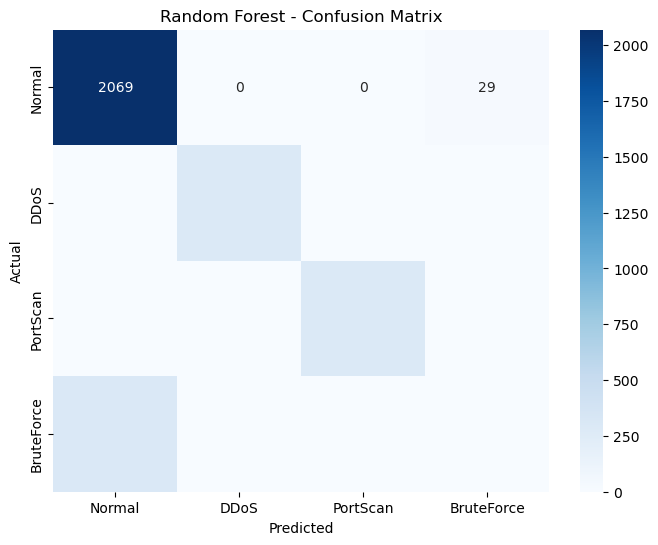


Evaluating SVM...

Classification Report:
              precision    recall  f1-score   support

      Normal       0.88      0.57      0.69      2098
        DDoS       1.00      1.00      1.00       298
    PortScan       0.98      0.99      0.98       300
  BruteForce       0.13      0.45      0.21       304

    accuracy                           0.64      3000
   macro avg       0.75      0.75      0.72      3000
weighted avg       0.82      0.64      0.70      3000



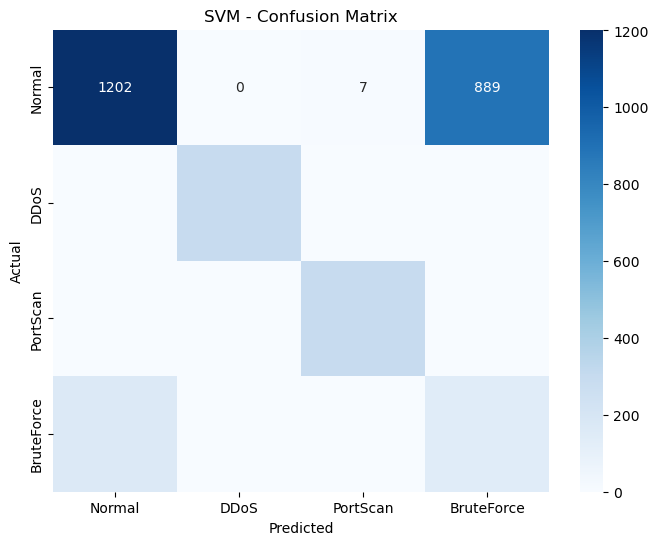


Evaluating Neural Network...

Classification Report:
              precision    recall  f1-score   support

      Normal       0.87      1.00      0.93      2098
        DDoS       1.00      1.00      1.00       298
    PortScan       0.98      0.99      0.98       300
  BruteForce       0.00      0.00      0.00       304

    accuracy                           0.90      3000
   macro avg       0.71      0.75      0.73      3000
weighted avg       0.81      0.90      0.85      3000



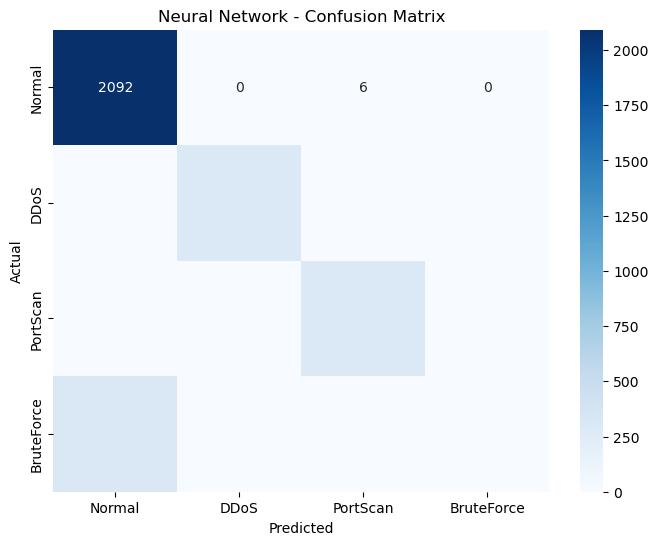

In [5]:
# Cell 5: Model Evaluation
def evaluate_models(models, scalers, X_test, y_test):
    
    results = {}
    class_names = ['Normal', 'DDoS', 'PortScan', 'BruteForce']
    
    for name, model in models.items():
        print(f"\nEvaluating {name}...")
        
        X_test_processed = X_test
        
        if name in ['SVM', 'Neural Network']:
            y_pred = model.predict(X_test_processed)
            y_proba = model.predict_proba(X_test_processed)
        else:
            y_pred = model.predict(X_test_processed)
            y_proba = model.predict_proba(X_test_processed) if hasattr(model, 'predict_proba') else None
        
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, target_names=class_names))
        
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=class_names, yticklabels=class_names)
        plt.title(f'{name} - Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
        
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr') if y_proba is not None else None
        
        results[name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc
        }
    
    return results

# Prepare models and evaluate
models = {
    'Random Forest': rf,
    'SVM': svm,
    'Neural Network': nn
}
scalers = {
    'SVM': None,
    'Random Forest': None,
    'Neural Network': None
}

results = evaluate_models(models, scalers, X_test, y_test)




=== Feature Importance Analysis ===


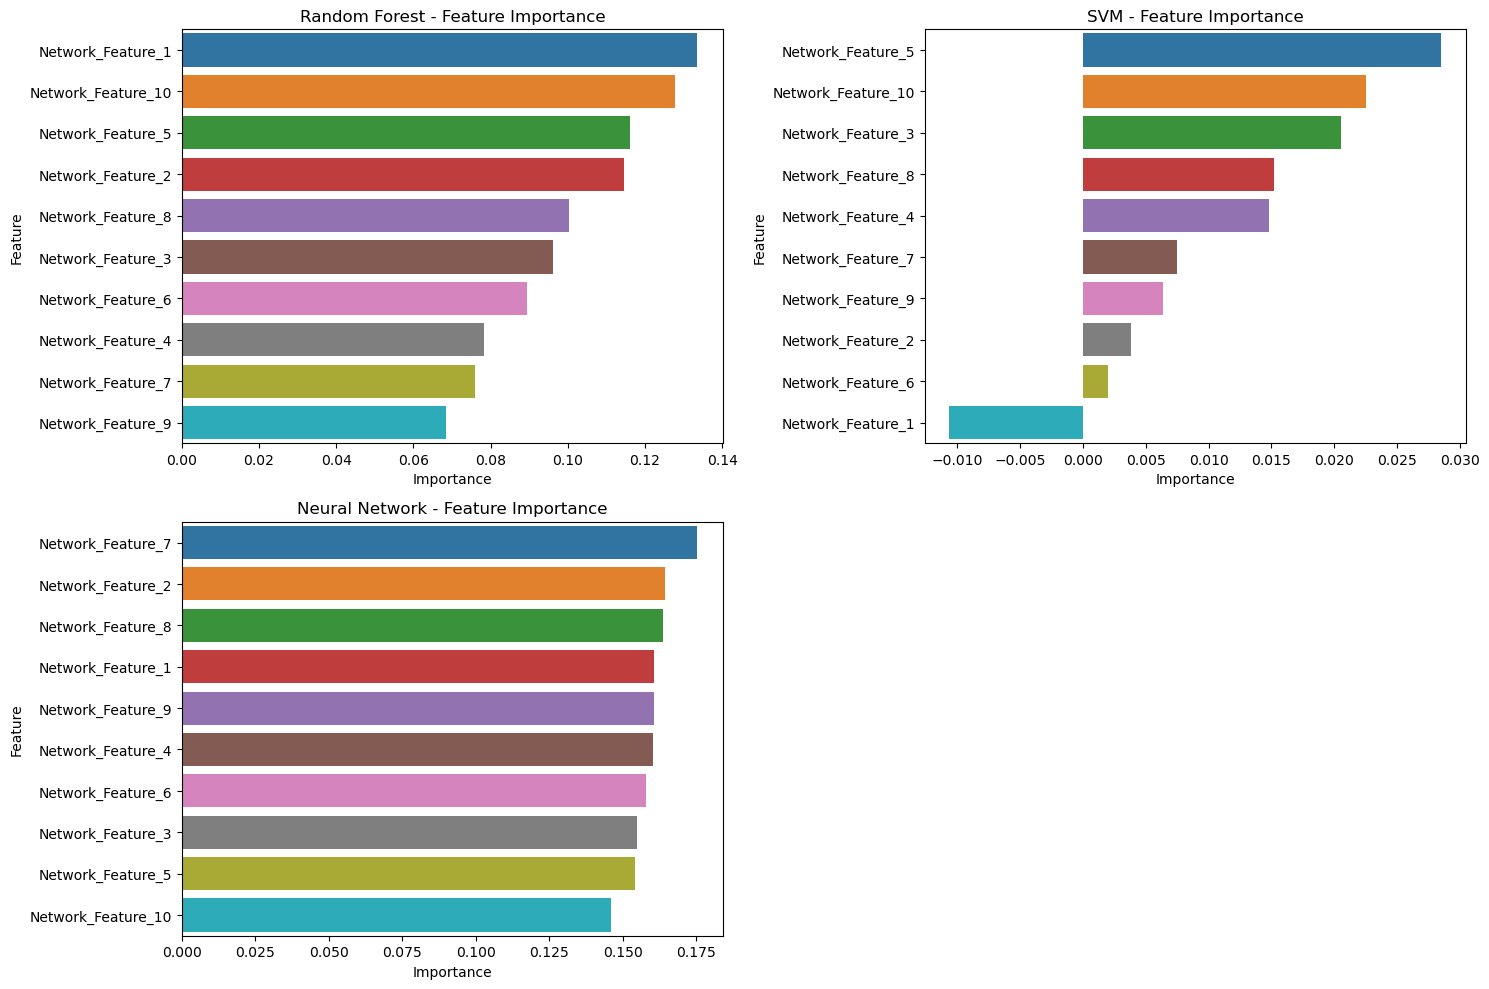

In [6]:
# Cell 6: Feature Importance Analysis
def analyze_feature_importance(models, selected_features, X_test, y_test):
    print("\n=== Feature Importance Analysis ===")
    plt.figure(figsize=(15, 10))
    
    for i, (name, model) in enumerate(models.items(), 1):
        plt.subplot(2, 2, i)
        
        if name == 'Random Forest':
            importances = model.feature_importances_
        elif name == 'SVM':
            from sklearn.inspection import permutation_importance
            result = permutation_importance(
                model.named_steps['svc'],
                model.named_steps['standardscaler'].transform(X_test),
                y_test,
                n_repeats=10,
                random_state=42
            )
            importances = result.importances_mean    
        elif name == 'Neural Network':
            mlp = model.named_steps['mlpclassifier']
            importances = np.mean(np.abs(mlp.coefs_[0]), axis=1)
        else:
            continue
        
        importance_df = pd.DataFrame({
            'Feature': selected_features,
            'Importance': importances
        }).sort_values('Importance', ascending=False)
        
        sns.barplot(x='Importance', y='Feature', data=importance_df)
        plt.title(f'{name} - Feature Importance')
    
    plt.tight_layout()
    plt.show()

analyze_feature_importance(models, selected_features, X_test, y_test)


In [7]:
# Cell 7: Final Results Comparison
print("\n=== Final Model Comparison ===")
comparison_df = pd.DataFrame(results).T
print(comparison_df)



=== Final Model Comparison ===
                accuracy  precision    recall        f1   roc_auc
Random Forest   0.888333   0.815101  0.888333  0.846830  0.861454
SVM             0.644667   0.823243  0.644667  0.703049  0.857098
Neural Network  0.895333   0.806863  0.895333  0.848167  0.858419
